# Integrantes

Moresco Brisa

Britos Julián Francisco

# Librerías

In [139]:
#!pip install pandas
#!pip install seaborn
#!pip install -U scikit-learn
#!pip install numpy

In [332]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import SGDRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Carga de datos

In [283]:
# Carga datos de dataset
# Contiene aproximadamente 10 años de observaciones diarias de variables climáticas: temperatura, dirección y velocidad del viento, humedad, presión, nubosidad, y cantidad de lluvia en mm.
# tras observar los datos del día de hoy, el objetivo es predecir las variables target:
#                                                                                     -RainFallTomorrow: cantidad de lluvia del día posterior a la observación. Problema de Regresión.
#                                                                                     -RainTomorrow: si el día siguiente llueve o no llueve. Problema de Clasificación.
file_path= 'weatherAUS.csv'
weather_data = pd.read_csv(file_path, sep=',',engine='python')

# Visualización de datos

In [284]:
# Vista de datos
weather_data.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2


In [285]:
# Columnas
weather_data.columns

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

In [286]:
# Tipos de variables
weather_data.dtypes

Unnamed: 0            int64
Date                 object
Location             object
MinTemp             float64
MaxTemp             float64
Rainfall            float64
Evaporation         float64
Sunshine            float64
WindGustDir          object
WindGustSpeed       float64
WindDir9am           object
WindDir3pm           object
WindSpeed9am        float64
WindSpeed3pm        float64
Humidity9am         float64
Humidity3pm         float64
Pressure9am         float64
Pressure3pm         float64
Cloud9am            float64
Cloud3pm            float64
Temp9am             float64
Temp3pm             float64
RainToday            object
RainTomorrow         object
RainfallTomorrow    float64
dtype: object

In [287]:
# Estadísticas descriptivas
weather_data.describe(include='all')

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
count,145412.000000,145412,145412,143928.000000,144159.000000,142152.000000,82658.000000,75616.000000,135096,135159.000000,...,140907.000000,130351.000000,130388.000000,89542.000000,86076.000000,143646.000000,141805.000000,142152,142153,142153.000000
unique,NaN,3435,49,NaN,NaN,NaN,NaN,NaN,16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NaN
top,NaN,2013-11-11,Canberra,NaN,NaN,NaN,NaN,NaN,W,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,NaN
freq,NaN,49,3435,NaN,NaN,NaN,NaN,NaN,9910,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110276,110281,NaN
mean,72728.184393,NaN,NaN,12.195873,23.223176,2.361516,5.468616,7.611241,NaN,40.036564,...,51.537432,1017.649277,1015.255184,4.447287,4.509770,16.992780,21.685249,NaN,NaN,2.361242
std,41990.722236,NaN,NaN,6.398018,7.118770,8.479338,4.193871,3.785612,NaN,13.607212,...,20.796720,7.107132,7.037981,2.887161,2.720306,6.488045,6.936358,NaN,NaN,8.479084
min,0.000000,NaN,NaN,-8.500000,-4.800000,0.000000,0.000000,0.000000,NaN,6.000000,...,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,NaN,NaN,0.000000
25%,36362.750000,NaN,NaN,7.600000,17.900000,0.000000,2.600000,4.800000,NaN,31.000000,...,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,NaN,NaN,0.000000
50%,72727.500000,NaN,NaN,12.000000,22.600000,0.000000,4.800000,8.400000,NaN,39.000000,...,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,NaN,NaN,0.000000
75%,109093.250000,NaN,NaN,16.900000,28.200000,0.800000,7.400000,10.600000,NaN,48.000000,...,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,NaN,NaN,0.800000


In [288]:
# Cantidad de valores faltantes.
weather_data.isna().sum()

Unnamed: 0              0
Date                    0
Location                0
MinTemp              1484
MaxTemp              1253
Rainfall             3260
Evaporation         62754
Sunshine            69796
WindGustDir         10316
WindGustSpeed       10253
WindDir9am          10562
WindDir3pm           4226
WindSpeed9am         1767
WindSpeed3pm         3061
Humidity9am          2653
Humidity3pm          4505
Pressure9am         15061
Pressure3pm         15024
Cloud9am            55870
Cloud3pm            59336
Temp9am              1766
Temp3pm              3607
RainToday            3260
RainTomorrow         3259
RainfallTomorrow     3259
dtype: int64

# Reducción de dimensionalidad

Eliminamos las localidades que no nos interesan predecir

In [289]:
# Lista de ubicaciones deseadas
ubicaciones_deseadas = ['Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']

# Filtra el DataFrame para que solo contenga las ubicaciones deseadas
weather_data = weather_data[weather_data['Location'].isin(ubicaciones_deseadas)]

Eliminamos las siguientes columnas:
- Location: eliminamos esta columna, ya que vamos a tomar las ubicaciones:
'Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport' como la si fueran una misma y así simplificar el modelo
- Unnamed: 0: Eliminamos esta columna, ya que no aporta nada de información al modelo


In [290]:
weather_data = weather_data.drop(['Unnamed: 0', 'Date', 'Location'], axis=1)

weather_data

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
6047,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,6.0,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,0.0
6048,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,19.0,...,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,0.0
6049,15.5,34.1,0.0,12.6,13.3,SE,30.0,NaN,N,NaN,...,7.0,NaN,1011.6,NaN,1.0,NaN,32.7,No,No,0.0
6050,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,30.0,...,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,0.0
6051,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,6.0,...,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102515,6.2,16.3,0.0,NaN,NaN,N,41.0,N,NW,24.0,...,70.0,1026.3,1024.1,NaN,NaN,8.7,15.5,No,Yes,2.0
102516,8.7,13.2,2.0,NaN,NaN,S,20.0,NaN,SE,0.0,...,82.0,1029.2,1028.3,NaN,8.0,11.1,12.0,Yes,No,0.0
102517,7.0,15.7,0.0,NaN,NaN,N,31.0,N,NNW,13.0,...,67.0,1027.0,1022.4,8.0,NaN,10.0,14.9,No,No,0.0
102518,5.4,16.2,0.0,NaN,NaN,N,37.0,NNW,W,24.0,...,70.0,1017.0,1014.4,8.0,4.0,6.4,14.9,No,Yes,2.2


# Separación de datos

Separamos el Dataframe según sean sus datos continuos o categóricos para un mejor tratamiento de los mismo.

In [291]:
# Separa las columnas categóricas
columnas_categoricas = weather_data.select_dtypes(include=['object'])

In [292]:
columnas_categoricas.dtypes

WindGustDir     object
WindDir9am      object
WindDir3pm      object
RainToday       object
RainTomorrow    object
dtype: object

In [293]:
# Separa las columnas continuas
columnas_continuas = weather_data.select_dtypes(include=['float64', 'int64'])

In [294]:
columnas_continuas.dtypes

MinTemp             float64
MaxTemp             float64
Rainfall            float64
Evaporation         float64
Sunshine            float64
WindGustSpeed       float64
WindSpeed9am        float64
WindSpeed3pm        float64
Humidity9am         float64
Humidity3pm         float64
Pressure9am         float64
Pressure3pm         float64
Cloud9am            float64
Cloud3pm            float64
Temp9am             float64
Temp3pm             float64
RainfallTomorrow    float64
dtype: object

# Datos faltantes

### Eliminación

Verificamos si existen filas que contengan solo valores nulos.

In [295]:
# Contamos el número total de filas que tengan todos sus valores como nulos
columnas_continuas_nulas = columnas_continuas.isnull().all(axis=1).sum()

columnas_continuas_nulas


1

Vemos que si tiene una fila donde todos sus valores son nulos, así que la eliminamos.

In [296]:
columnas_continuas = columnas_continuas.dropna(how='all')

In [297]:
# Contamos el número total de filas que tengan todos sus valores como nulos
columnas_continuas_nulas = columnas_continuas.isnull().all(axis=1).sum()

columnas_continuas_nulas

0

In [298]:
# Contamos el número total de filas que tengan todos sus valores como nulos
columnas_categoricas_nulas = columnas_categoricas.isnull().all(axis=1).sum()

columnas_categoricas_nulas

64

### Completado

Verificamos si existen valores faltantes

In [299]:
columnas_categoricas.isnull().sum()

WindGustDir     1645
WindDir9am      1648
WindDir3pm       437
RainToday        986
RainTomorrow     985
dtype: int64

Rellenamos los datos faltantes con la moda.

In [300]:
for columna in columnas_categoricas.columns:
    columnas_categoricas[columna].fillna(columnas_categoricas[columna].mode()[0], inplace=True)


In [301]:
columnas_categoricas.isnull().sum()

WindGustDir     0
WindDir9am      0
WindDir3pm      0
RainToday       0
RainTomorrow    0
dtype: int64

Rellenamos los datos faltantes con la mediana.

In [302]:
columnas_continuas = columnas_continuas.fillna(columnas_continuas.median())

In [303]:
columnas_continuas.isnull().sum()

MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustSpeed       0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainfallTomorrow    0
dtype: int64

Seleccioné la mediana para rellenar los datos faltantes en mi dataframe de variables continuas porque la mediana es una medida de tendencia central que no se ve afectada por los valores extremos o atípicos. En mi conjunto de datos, había algunos valores que eran mucho más altos o bajos que el resto, y si hubiera usado la media para rellenar los datos faltantes, estos valores extremos habrían sesgado la media y distorsionado mis resultados. La mediana, al ser el valor medio de un conjunto de datos ordenado, proporciona una mejor representación del 'valor típico' en mi conjunto de datos, especialmente cuando hay valores atípicos.

En cuanto a mi dataframe de variables categóricas, seleccioné la moda para rellenar los datos faltantes porque la moda es la categoría que ocurre con más frecuencia en un conjunto de datos. Dado que las variables categóricas no son numéricas, medidas como la media y la mediana no tienen sentido en este contexto. Al rellenar los datos faltantes con la moda, estoy esencialmente asumiendo que la categoría más común es la más probable de ocurrir en los datos faltantes. Esto puede no ser siempre el caso, pero es una suposición razonable en ausencia de información adicional.

# Estandarización

In [304]:
# Crear el estandarizador
scaler = StandardScaler()

# Ajustar y transformar los datos
columnas_continuas_escaladas = scaler.fit_transform(columnas_continuas)

# Convertir el resultado a un DataFrame
columnas_continuas_escaladas = pd.DataFrame(columnas_continuas_escaladas, columns=columnas_continuas.columns)

In [305]:
columnas_continuas_escaladas

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
0,1.175466,2.009046,-0.314933,2.132768,1.562810,0.459195,-0.968277,-0.001206,-2.650101,-1.909583,-1.634667,-1.641642,-1.307323,-0.072696,1.973168,2.011902,-0.314813
1,1.263926,1.058516,-0.314933,2.950715,1.769692,-0.338857,0.414487,-0.113240,-2.107130,-2.164318,-0.732125,-0.566212,-1.727648,-1.874181,0.856556,1.022200,-0.314813
2,0.750854,1.843081,-0.314933,2.308043,1.858356,-0.846709,-0.223712,-1.457647,0.064756,-2.215265,0.019993,-0.636045,0.373978,-1.874181,-0.082817,1.903653,-0.314813
3,1.440847,2.371153,-0.314933,1.782220,1.060384,0.314095,1.584519,-0.561376,-1.455564,-1.451059,-0.814175,-0.971244,-1.727648,0.377676,2.345372,2.243863,-0.314813
4,1.883151,2.491855,-0.314933,1.957494,1.533256,-0.774159,-0.968277,-1.569681,-1.727050,-1.451059,-0.759475,-0.985210,-1.727648,-0.072696,2.416268,2.352112,-0.314813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28227,-0.894513,-0.842544,-0.314933,-0.204222,0.114639,-0.048656,0.946320,0.222861,1.096401,0.994398,1.100309,1.109783,0.373978,0.377676,-1.199429,-0.756170,0.003515
28228,-0.452210,-1.310265,0.003369,-0.204222,0.114639,-1.572211,-1.606476,-1.009511,1.585076,1.605763,1.496880,1.696381,0.373978,1.278419,-0.774053,-1.297413,-0.314813
28229,-0.752976,-0.933071,-0.314933,-0.204222,0.114639,-0.774159,-0.223712,-0.561376,1.259293,0.841557,1.196033,0.872351,1.214629,0.377676,-0.969017,-0.848955,-0.314813
28230,-1.036050,-0.857632,-0.314933,-0.204222,0.114639,-0.338857,0.946320,0.446929,1.150698,0.994398,-0.171455,-0.244979,1.214629,-0.523067,-1.607081,-0.848955,0.035347


# One hot enconding (Dummies)

In [306]:
columnas_categoricas

,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
6047,SSW,ENE,SW,No,No
6048,S,SSE,SSE,No,No
6049,SE,N,N,No,No
6050,NNE,NNE,NNW,No,No
6051,WNW,WNW,WSW,No,No
...,...,...,...,...,...
102515,N,N,NW,No,Yes
102516,S,N,SE,Yes,No
102517,N,N,NNW,No,No
102518,N,NNW,W,No,Yes


Al tener demasiadas variables categóricas en mi DataFrame, lo que hice fue simplificar la situación agrupándolas. Tenía una columna con direcciones de viento que incluía 16 categorías distintas como 'N', 'NNW', 'NNE', etc. Pero para mi análisis, no necesitaba tanta granularidad, así que decidí agrupar estas 16 categorías en solo 4: 'N', 'S', 'E' y 'W'.

Para hacer esto, creé un diccionario que mapeaba cada una de las 16 categorías a una de las 4 direcciones principales. Luego, utilicé la función map de pandas para aplicar este mapeo a mi columna. De esta manera, pude reducir la cantidad de categorías únicas en mi columna de 16 a solo 4, lo que simplificó mucho mi análisis

In [307]:
diccionario = {
    'N': ['N', 'NNW', 'NNE', 'NE', 'NW'],
    'S': ['S', 'SSW', 'SSE', 'SE', 'SW'],
    'E': ['E', 'ENE', 'ESE'],
    'W': ['W', 'WNW', 'WSW'],
}

# Invertir el diccionario para el mapeo
diccionario_invertido = {valor: clave for clave, lista_valores in diccionario.items() for valor in lista_valores}

# Aplicar la transformación a WindGustDir
columnas_categoricas['WindGustDir'] = columnas_categoricas['WindGustDir'].map(diccionario_invertido)

# Aplicar la transformación a WindDir9am
columnas_categoricas['WindDir9am'] = columnas_categoricas['WindDir9am'].map(diccionario_invertido)

# Aplicar la transformación a WindDir3pm
columnas_categoricas['WindDir3pm'] = columnas_categoricas['WindDir3pm'].map(diccionario_invertido)

columnas_categoricas


,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
6047,S,E,S,No,No
6048,S,S,S,No,No
6049,S,N,N,No,No
6050,N,N,N,No,No
6051,W,W,W,No,No
...,...,...,...,...,...
102515,N,N,N,No,Yes
102516,S,N,S,Yes,No
102517,N,N,N,No,No
102518,N,N,W,No,Yes


Usando la función de pandas get_dummies  aplicará One Hot Encoding a las columnas del Dataframe columnas_categoricas. El resultado será un nuevo DataFrame donde cada valor categórico único en cada columna se convierte en una nueva columna y se codifica como 1 o 0.

In [308]:
columnas_categoricas_encoded = pd.get_dummies(columnas_categoricas).astype('int64')

columnas_categoricas_encoded

,WindGustDir_E,WindGustDir_N,WindGustDir_S,WindGustDir_W,WindDir9am_E,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_E,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_No,RainToday_Yes,RainTomorrow_No,RainTomorrow_Yes
6047,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0
6048,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0
6049,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0
6050,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0
6051,0,0,0,1,0,0,0,1,0,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102515,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1
102516,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0
102517,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0
102518,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1


Elimino las columnas RainTomorrow_No y RainToday_No, ya que son columnas redundantes porque son perfectamente inversas a RainTomorrow_Yes y RainTomorrow_Yes, es decir, si un día tiene un '1' en 'RainTomorrow_No', entonces tiene un '0' en 'RainTomorrow_Yes', y viceversa.

In [309]:
columnas_categoricas_encoded = columnas_categoricas_encoded.drop(['RainTomorrow_No', 'RainToday_No'], axis=1)

columnas_categoricas_encoded

,WindGustDir_E,WindGustDir_N,WindGustDir_S,WindGustDir_W,WindDir9am_E,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_E,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes,RainTomorrow_Yes
6047,0,0,1,0,1,0,0,0,0,0,1,0,0,0
6048,0,0,1,0,0,0,1,0,0,0,1,0,0,0
6049,0,0,1,0,0,1,0,0,0,1,0,0,0,0
6050,0,1,0,0,0,1,0,0,0,1,0,0,0,0
6051,0,0,0,1,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102515,0,1,0,0,0,1,0,0,0,1,0,0,0,1
102516,0,0,1,0,0,1,0,0,0,0,1,0,1,0
102517,0,1,0,0,0,1,0,0,0,1,0,0,0,0
102518,0,1,0,0,0,1,0,0,0,0,0,1,0,1


# Matriz de correlación

Para hacer la matriz de correlación de nuestro dataframe primero vamos a tener que unir nuestros dataframes columnas_categoricas_encoded y columnas_continuas.

In [311]:
data_procesada = pd.concat([columnas_categoricas_encoded, columnas_continuas], axis=1)

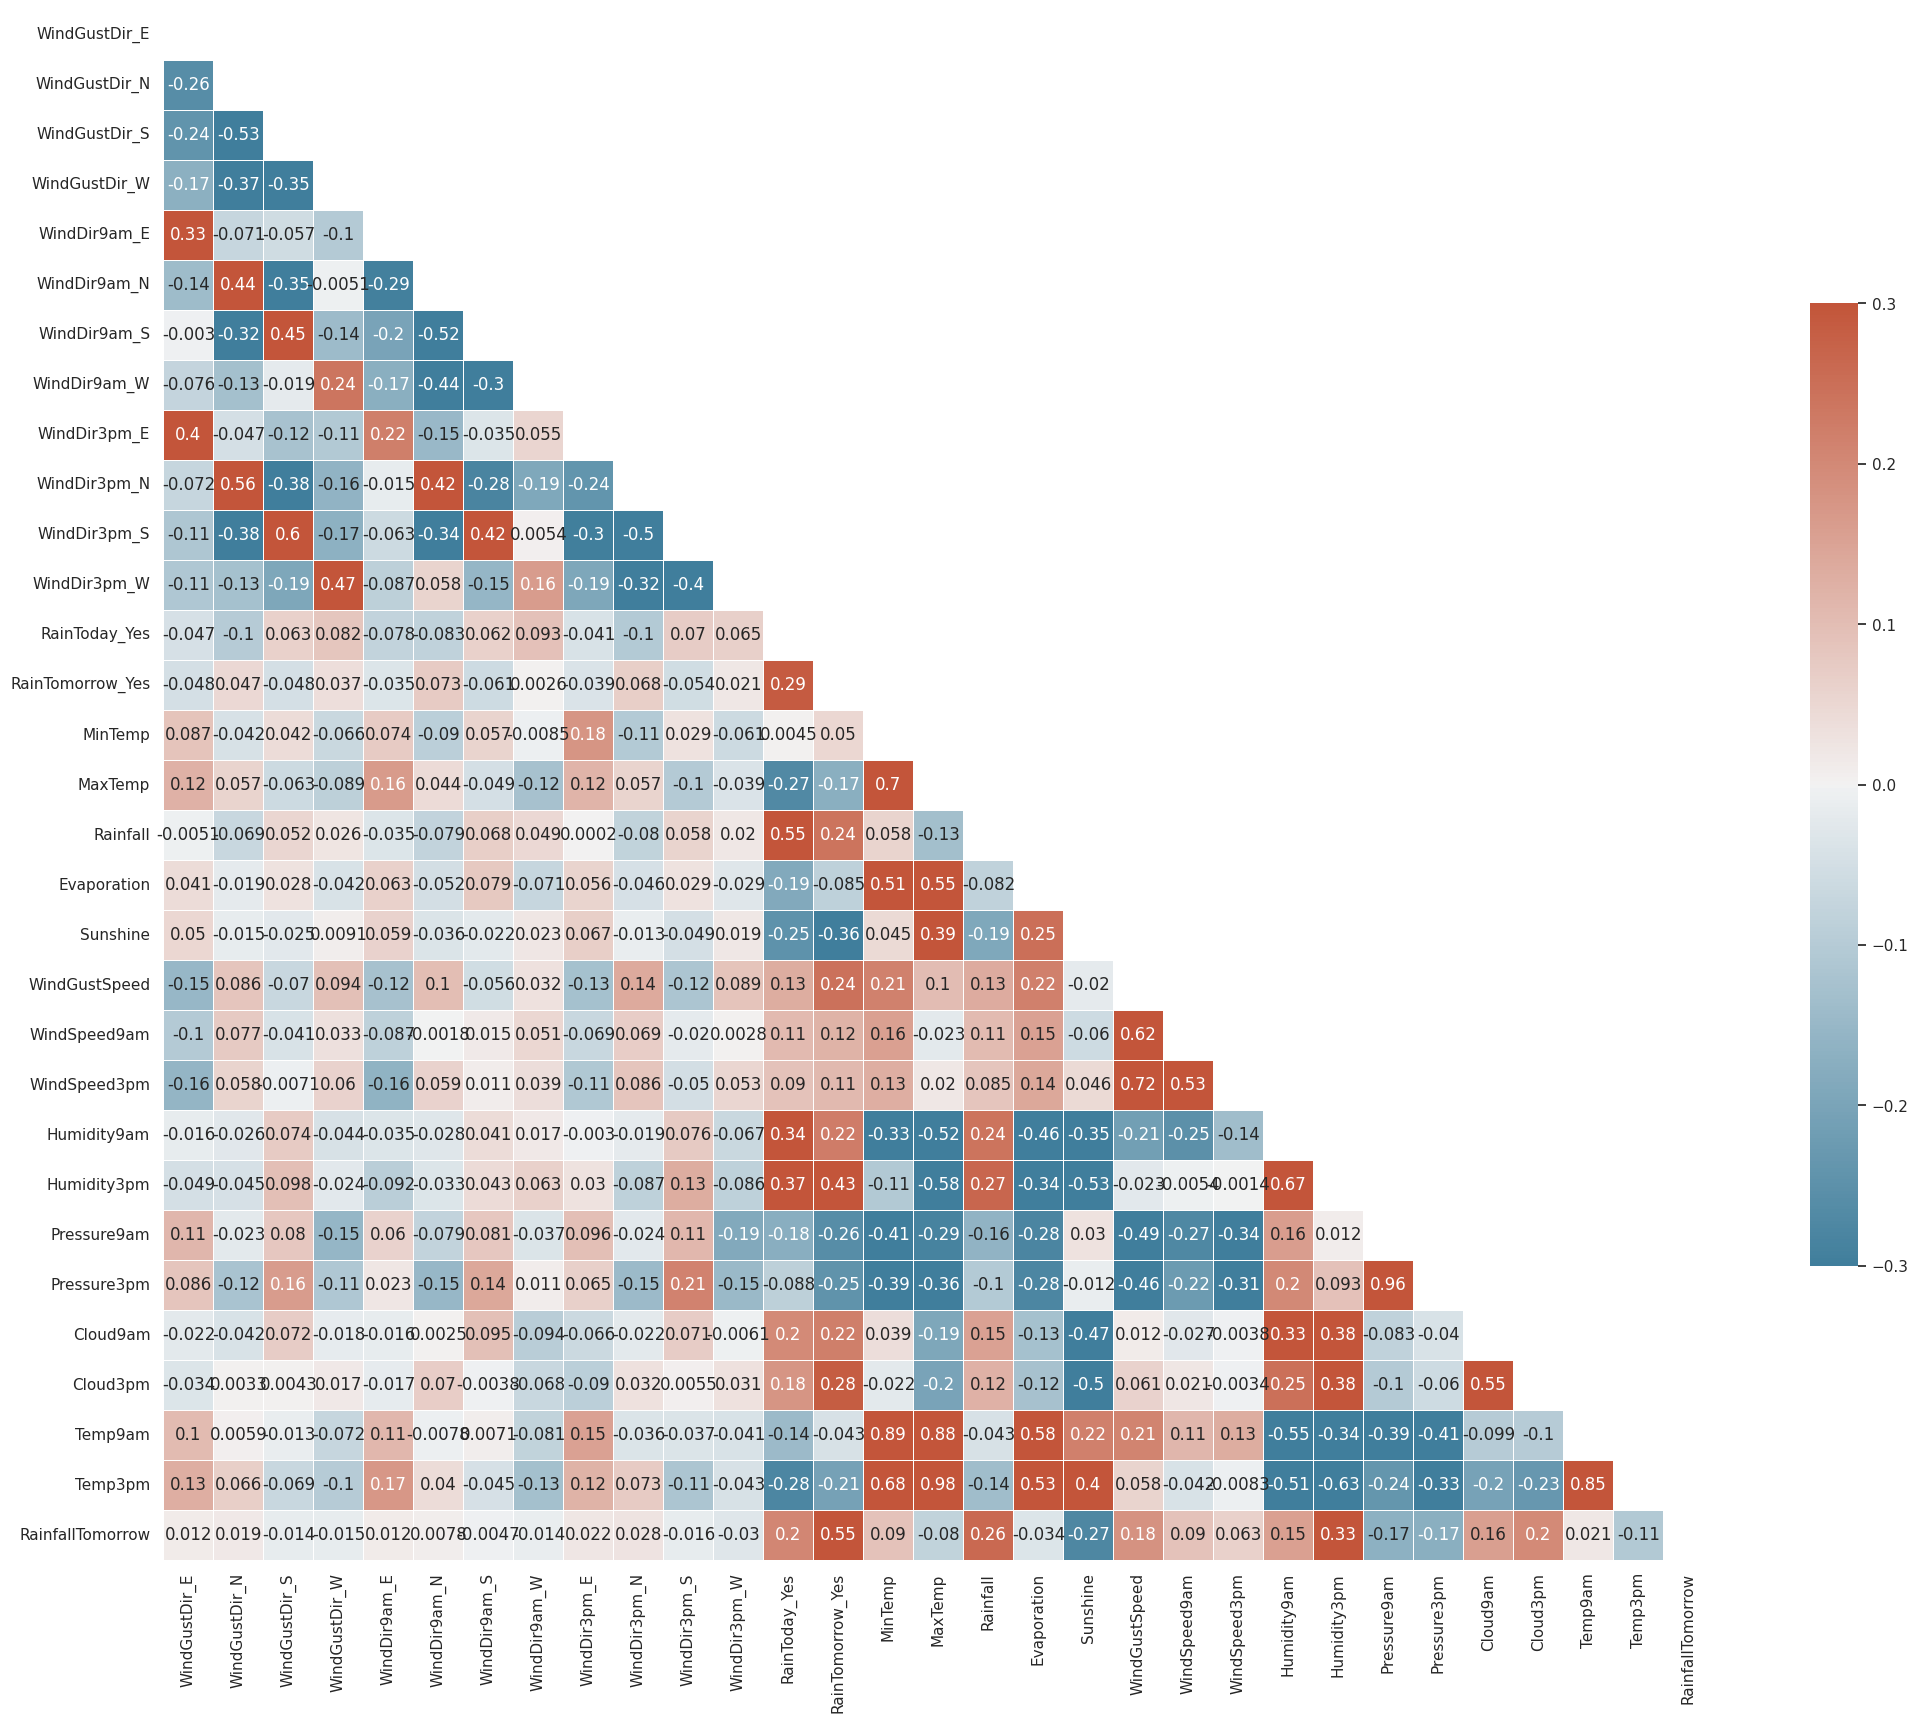

In [316]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = data_procesada.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.3 ,vmax=.3,center=0, square=True,annot=True ,linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

# Validación Cruzada K-Folds

# Regresión Lineal

In [338]:
from sklearn.model_selection import train_test_split

# Dividir los datos en características (X) y etiquetas (y)
X = data_procesada.drop(['RainTomorrow_Yes'], axis=1)  # Características
y = data_procesada['RainTomorrow_Yes']  # Etiquetas

# Dividir los datos en conjuntos de entrenamiento y prueba (y opcionalmente validación)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Si deseas incluir un conjunto de validación, puedes dividir X_train y y_train nuevamente
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Ahora X_train, X_test, y_train, y_test (y opcionalmente X_val, y_val) contienen tus datos divididos


In [339]:
import numpy as np
from sklearn.impute import SimpleImputer

# Encuentra las filas con valores faltantes en el conjunto de validación
filas_con_nan_val = np.isnan(X_val).any(axis=1) | np.isnan(y_val)

# Elimina las filas correspondientes de X_val e y_val
X_val_cleaned = X_val[~filas_con_nan_val]
y_val_cleaned = y_val[~filas_con_nan_val]

# Instanciar el imputador
imputer = SimpleImputer(strategy='mean')

# Ajustar y transformar los datos de entrenamiento
X_train_imputed = imputer.fit_transform(X_val_cleaned)
y_train_imputed = y_val_cleaned  # No hay necesidad de imputar las etiquetas

# Transformar los datos de validación
X_val_imputed = imputer.transform(X_val_cleaned)

# Continuar con el entrenamiento del modelo y la evaluación en el conjunto de validación


In [340]:
# Crea una instancia del modelo de regresión lineal
model = LinearRegression()
model.fit(X_train_imputed, y_train_imputed)


LinearRegression()

In [345]:
y_pred_val = model.predict(X_val_imputed)


In [344]:

coefficients = model.coef_
intercept = model.intercept_
print("Coefficients:", coefficients)
print("Intercept:", intercept)

# MSE: Error Cuadratico Medio
mse = mean_squared_error(y_test, y_pred_val)

# R^2
r2 = r2_score(y_test, y_pred_val)

# MAE: Error Absoluto Medio
mae = mean_absolute_error(y_test, y_pred_val)

# RMSE: Raíz del Error Cuadrático Medio
rmse = np.sqrt(mean_squared_error(y_test, y_pred_val))

print(f"\nR^2: {r2}\n")
print(f"MSE(Error Cuadratico Medio): {mse}\n")
print(f"MAE(Error Absoluto Medio): {mae}\n")
print(f"RMSE(Raíz del Error Cuadrático Medio): {rmse}\n")

Coefficients: [ 7.53802236e+10  7.53802236e+10  7.53802236e+10  7.53802236e+10
  7.84381686e-03  2.59416306e-02 -2.94729092e-02 -4.67925540e-03
 -3.55362539e-03 -4.78725287e-03 -1.11059142e-02  1.98533728e-02
  9.17184642e-02 -5.36752700e-04 -9.64211930e-04 -1.60572888e-03
 -5.08004518e-04 -1.29718781e-02  5.86700439e-03 -2.13623047e-03
 -2.49862671e-03 -1.35231018e-03  6.27517700e-03  1.99508667e-03
 -9.51957703e-03  4.96864319e-04  4.93288040e-03 -4.61578369e-03
  4.06265259e-03  2.33788490e-02]
Intercept: -75380223576.60359

R^2: -0.43731779966307216

MSE(Error Cuadratico Medio): 0.26053465776741985

MAE(Error Absoluto Medio): 0.3724482046390437

RMSE(Raíz del Error Cuadrático Medio): 0.5104259571842128



# Gradiente descendiente

In [350]:
# Regresión lineal utilizando SGDRegressor
model_sgd = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
model_sgd.fit(X_train_imputed, y_train_imputed)

SGDRegressor(random_state=42)

In [353]:
y_pred_sgd = model_sgd.predict(X_val_imputed)

In [354]:
# Coeficientes
coefficients_sgd = model_sgd.coef_
intercept_sgd = model_sgd.intercept_
print("Coefficients (SGD):", coefficients_sgd)
print("Intercept (SGD):", intercept_sgd)

# MSE: Error Cuadrático Medio
mse_sgd = mean_squared_error(y_test, y_pred_sgd)

# R^2
r2_sgd = r2_score(y_test, y_pred_sgd)

# MAE: Error Absoluto Medio
mae_sgd = mean_absolute_error(y_test, y_pred_sgd)

# RMSE: Raíz del Error Cuadrático Medio
rmse_sgd = np.sqrt(mse_sgd)

print(f"\nR^2 (SGD): {r2_sgd}\n")
print(f"MSE (SGD): {mse_sgd}\n")
print(f"MAE (SGD): {mae_sgd}\n")
print(f"RMSE (SGD): {rmse_sgd}\n")

Coefficients (SGD): [ 1.93107143e+10  1.23411778e+11  1.39818245e+11 -2.83379285e+11
  3.44957768e+10  3.04695347e+10 -5.06149539e+10 -1.51889050e+10
 -3.49989180e+10  8.99693976e+10  7.08574646e+10 -1.26666492e+11
  1.28216894e+11 -1.23536025e+12 -1.16703006e+12  7.36120425e+11
 -4.25960313e+11 -1.00815811e+12  8.38080407e+11  2.23158036e+12
  1.33678228e+12  6.40679143e+11  6.83250691e+11  4.33221415e+11
  1.36305519e+11  3.98854998e+11  6.79794663e+11 -1.25573639e+12
 -1.02928682e+12 -2.66874717e+11]
Intercept (SGD): [-8.50890004e+08]

R^2 (SGD): -2.5011847015616512e+30

MSE (SGD): 4.533759342486581e+29

MAE (SGD): 670867594012762.6

RMSE (SGD): 673331964374674.6



# Lasso

In [355]:
lasso = Lasso(alpha=0.1)

lasso.fit(X_train_imputed, y_train_imputed)

Lasso(alpha=0.1)

In [359]:
print("\nCoeficientes del modelo Lasso:")
print(lasso.coef_)
print("Lasso Score df_train:", lasso.score(X_val_imputed, y_test))
print("Lasso Score df_test:", lasso.score(X_val_imputed, y_test))


Coeficientes del modelo Lasso:
[-0.          0.         -0.          0.         -0.          0.
 -0.         -0.         -0.          0.         -0.          0.
  0.         -0.         -0.          0.         -0.         -0.00498178
  0.00407    -0.         -0.          0.          0.00653347 -0.
 -0.00687239  0.          0.         -0.         -0.          0.0222496 ]
Lasso Score df_train: -0.3703774443429626
Lasso Score df_test: -0.3703774443429626


# Ridge

In [356]:
ridge = Ridge(alpha=0.1)

ridge.fit(X_train_imputed, y_train_imputed)

Ridge(alpha=0.1)

In [360]:
print("\nCoeficientes del modelo Ridge:")
print(ridge.coef_)
print("Ridge Score df_train:", ridge.score(X_val_imputed, y_test))
print("Ridge Score df_test:", ridge.score(X_val_imputed, y_test))


Coeficientes del modelo Ridge:
[-0.01478631  0.00392429  0.00735489  0.00350713  0.00803798  0.02603317
 -0.02938644 -0.00468471 -0.00368095 -0.004787   -0.01126296  0.01973092
  0.09161439 -0.00053061 -0.0009961  -0.00160459 -0.00050816 -0.01298443
  0.00587272 -0.00213724 -0.00252488 -0.00135655  0.00626425  0.00199155
 -0.0095109   0.00049541  0.00491571 -0.00459844  0.00409509  0.02339328]
Ridge Score df_train: -0.4368994858291906
Ridge Score df_test: -0.4368994858291906
